In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st

In [2]:
#This ensures that the plots are displayes automatically without need to call plt.show().
%matplotlib inline
fig_height = 10
fig_width =15
plt.rcParams["figure.figsize"] = [fig_width, fig_height] #Setting the default figure size for  plotting.

# Probability based methods

Actually most of the machine learning methods are "probability based". For example consider the  classification problem. We have an _examplar_ with some features $d$ and we want to decide to which class $c$ it belong. One way of solving this problem is to calculate the conditional probability 

$$P(C = c|D = d)$$

that given the features  $d$ the class is $c$. 

It is more useful to talk  about the probability then  a deterministic  classifier function such that $f(d)=c$. In most real life scenarios such function just does not exists. E.g. when approving a loan we have no way of knowing for certain that particular person will repay or not his loan regardless of the information we have on him. We can only  to some degree estimate the probability of that event. If have a reliable estimate of this conditional probability we can use it to make decision(clasification) but  e.g. choose the amount of risk we are willing to take. 

## Generative methods

The whole crux of  machine learning is to reliably estimate this conditional probability. Methods that try  to estimate $P(C = c|D = d)$ directly from the data are called _discriminative_. 
In this  lecture I will concentrate on the _generative_ methods. Generative methods try to estimate (learn) the joint probability distribution

$$P(C=c,D=d)$$

Once we have it we can calculate the conditional probability directly from the definition

$$P(C=c|D=d)=\frac{P(C=c,D=d)}{P(D=d)}$$

## Bayes theorem

In practice it is often easier to use the Bayes theorem

$$\boxed{P(C=c|D=d) = \frac{P(D=d|C)P(C=c)}{P(D=d)}= \frac{P(D=d|C=c)P(C=c)}{\sum_c P(D=d|C=c)P(C=c)}}$$ 

In other words we are factoring the joint probability in two parts

$$P(C=c, D=d)= P(D=d|C=c)\cdot P(C=c)$$

__Sampling distribution__

The first factor  when viewed as the function of $d$ is called the _sampling distributions_ as it describes the distribution of samples in class $c$. Knowledge of $P(D=d|C=c)$ is the knowledge of how to generate the data. We can say we have a model of our data generation process. 

__Prior__

$P(C=c)$ is an  _a priori_ (prior) probability y of $C=c$ before we gather any data.  That's the knowledge we had about random variable $C$ beforehand. That  usually reflects the frequency of occurence of classes in the data. For example it may be a fraction of people that repay their loans. 

## Bayes classifier

Given this probability we can construct a classifier _e.g._ by chosing the class with highest probability

$$\newcommand{\argmax}{\operatorname{argmax}}$$
$$c = \argmax_c P(C=c|D=d)  =  \argmax_{c} \frac{P(D=d|C=c)P(C=c)}{P(D=d)}=\argmax_{C} P(D=d|C=c)P(C=c)$$

Please note that for that kind of classifier  we do not need to calculate the denominator. However in the next section we will see that having a proper probability distribution allows us to construct a whole familly of classifiers. We are not restricted to choosing the one above.

## Example: Estimating sex of a person based on it's height

Let's consider classfication of persons as women and men based on their height. 

In this case $D$ is the height of a person and we will denote it by $H$,  $C$ is the sex of a person and we will denote it by $S$. 

We will assume that for each sex the height distribution is Gaussian (we will check this assumption later)

$$P(H=h|S=s) \sim  \mathcal{N}(\mu_s,\sigma_s)$$

I will use $\sim$ symbol to denote that the probability on left-hand side is equal to probability density function (pmf) or probability mass function (pmf) of the distribution on the right-hand side. 

To model this we will use  `stats` module from `scipy` which we have imported at the begining of the notebook.

In [3]:
pd_h_cond_F = st.norm(166,6.1)
pd_h_cond_M = st.norm(178,7)

The numbers were taken from the publication [Women in Poland](https://stat.gov.pl/cps/rde/xbcr/gus/Kobiety_w_Polsce.pdf) published by Polish Central Statistical Office (page 82).

Those are objects representing distributions and have methods for calculating probability distribution functions. Functions in Python are first class objects and we can assign them to variables

In [4]:
pdf_h_cond_F = pd_h_cond_F.pdf
pdf_h_cond_M = pd_h_cond_M.pdf

We also need _a priori_ probability $P(S=s)$ that a person is a woman or a man. We will assume an equal a priori distribution of sexes

In [5]:
p_F = 0.5
p_M = 0.5

Please keep in mind that this has to be adjusted for the particular use case. E.g. it will not be true for students or employes of our faculty. 

The probability that a person is woman given its height

$$P(f|h)\equiv P(S=f|H=h)$$

is easilly calculated from Bayes theorem

$$P(f|h)= \frac{P(H=h|S=f)P(S=f)}{P(H=h|S=f)P(S=f)+P(H=h|S=m)P(S=m)}$$

Which can be translated into the python function

In [6]:
def pdf_F_cond(h):
    return pdf_h_cond_F(h)*p_F/(pdf_h_cond_F(h)*p_F+pdf_h_cond_M(h)*p_M)

Let's see how this  distribution looks like:

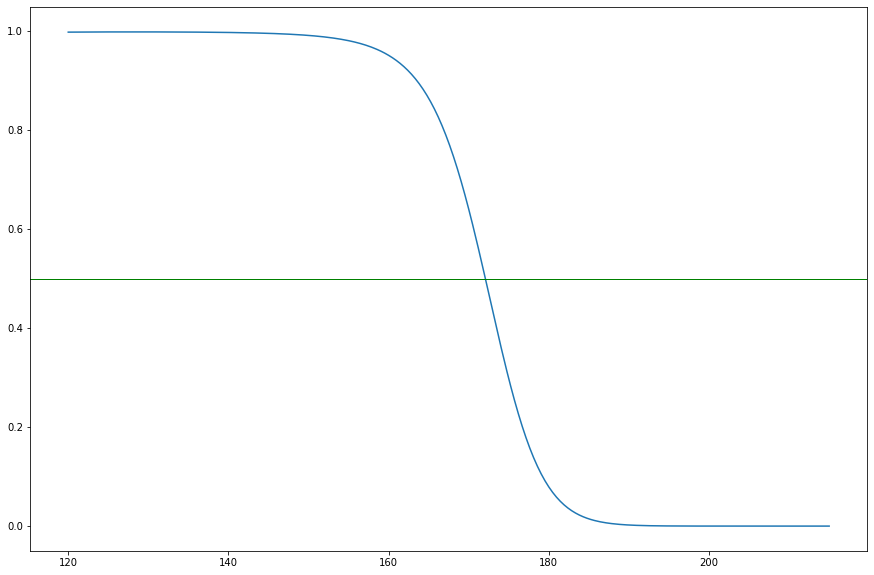

In [7]:
hs = np.linspace(120,215,400)
plt.plot(hs,pdf_F_cond(hs));
plt.axhline(0.5, linewidth=1, c='green');

As we have only two classes chosing the class with bigger probability means that we 
classify a person as woman when this probability is greater then $1/2$. We will show later that this is in some sense optimal threshold.  Solving for that, we obtain that the height threshold is 

In [8]:
from scipy.optimize import fsolve
threshold = fsolve(lambda h: pdf_F_cond(h)-0.5, 160)
print(f"{threshold.item():.1f}cm :)")

172.1cm :)


In other words if our assumptions hold a person lower then 172cm has a greater chance of being a woman then a man.

### Problem

How does this probability change when the _a priori_ probabilities are not equal?  Assume that $P(S=f)=1/4$  and $P(S=m)=3/4$ which is probably closer to reality among computer science students. Plot the new $P(f|h)$ together with the old one. What is the  height treshold now? 

#### Answer

This is not necessary but I will  define a function that creates a desired probability distribution:

In [9]:
def make_pdf_F_cond_h(p_F):
    p_M = 1-p_F
    def pdf(h):
         return pdf_h_cond_F(h)*p_F/(pdf_h_cond_F(h)*p_F+pdf_h_cond_M(h)*p_M)
    
    return pdf

This function returns another function so it is an example of [_higher order function_](https://en.wikipedia.org/wiki/Higher-order_function). The returned function is actually a [_closure_](https://simple.wikipedia.org/wiki/Closure_(computer_science)) as it remembers (closes over) the value of ```p_F```. 

In [10]:
pdf_F_cond_fac = make_pdf_F_cond_h(0.25)

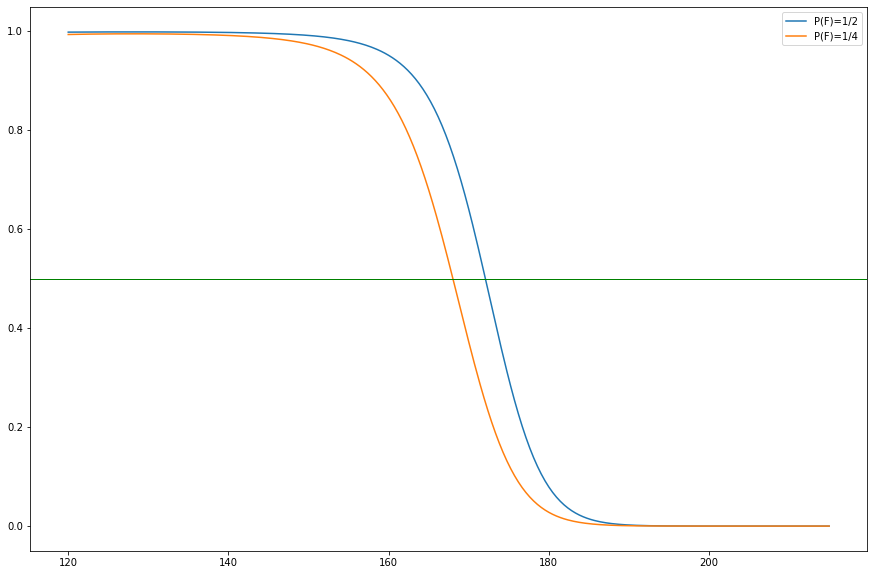

In [11]:
hs = np.linspace(120,215,400)
plt.plot(hs,pdf_F_cond(hs), label='P(F)=1/2');
plt.plot(hs,pdf_F_cond_fac(hs), label='P(F)=1/4');
plt.axhline(0.5, linewidth=1, c='green');
plt.legend();

In [12]:
from scipy.optimize import fsolve
threshold_fac = fsolve(lambda h: pdf_F_cond_fac(h)-0.5, 160)
print(f"{threshold_fac.item():5.1f}cm")

168.0cm


As the women are now more rare  the treshold is now considerably lower. In extreme case if $P(S=f)=0$, think _e.g._ about all-boy's schools, then whathever  the height of the person, it has to be a man and treshold would be zero. 

# Errors

Of course this is very crude classifier. There are tall women and small men and classifier will make errors. Please note that those error are inherent in the problem, height by itself just does not provide enough information. But notion of error  as well as the concept of the  optimal classifier  requires some explanations. This we will discuss in the next section. 

## Binary classification

Our classifier is an example of binary classfier which can have only two outcomes: woman or man. It is customary the refer to those outcomes as positive and negative. 

## Confusion matrix

The performance of the binary classfier can be represented by a matrix, called _confusion matrix_:

<table style="font-size:1.5em;">
<tr> <th/><th>        </th> <th colspan=2>actual</th></tr>
<tr> <th/><th> </th><th>P</th><th>N</th></tr>
<tr> <th/><th>predicted</th><th>F</th><th>M</th></tr>
<tr> <th>P</th><th> F </th> <td>TP</td> <td>FP</td></tr>
<tr> <th>N</th><th> M </th> <td>FN</td> <td>TN</td></tr>
<tr> <th colspan=2>total</th> <td> P</td> <td>N</td></tr>
</table>

The columns of the matrix correspond to real classes and  rows to the outcome of the classifier. On the diagonal we have good clasification: true positives and true negatives. In our example those are women classified as women and men classified as men. 

The off diagonal terms represent misclasification: false positives - men classified as women and false negatives - women classified as men. Please note that those are different types of errors and may have totally different consequences ! _E.g._ In medical tests classifying healthy person as ill has radically different consequence than clasyfying an ill person as healthy. 

False positives are also refered to as **Type I** errors and false negatives as **Type II** errors.

In the above table I have somewhat missused the notation. The letters P and N  stand not only for "positive" and "negative" but also for the number of positives and negatives. I hope that the meaning will be clear from the context. 

Those absolute numbers can be converted into rates:

### Rates
$
\begin{array}{cccccc}
TPR & = &\frac{TP}{P},&\quad FPR & = &\frac{FP}{N} \\
FNR & = &\frac{FN}{P},&\quad TNR & = &\frac{TN}{N} \\
  total  &   & 1             &\quad     &   & 1 
\end{array}
$

For example the true positives rate (TPR) is the fraction of women classified as women, and false positive rate  (FPR) is the fraction of men classified as women.

Some other quantities used to measure the performance of the binary classifier include

__Accuracy__ is the fraction of correct classifications

$$\frac{TP+TN}{P+N}$$

__Recall__ is another name for true positive rate 

__Precision__ is the fraction of true positive cases in all cases classified as positive

$$\frac{TP}{TP+FP}$$ 

This can be viewed as the probability that given positive results that examplar is really a positive. 

$\mathbf{F_1}$ score is the harmonic mean  of precision and recall (TPR) 

$$2\cdot\frac{precision\cdot recall}{precision + recall} = \frac{2\cdot TP}{TP+FP+P}$$

__Problem__ Medical test

Consider a rare disease (1 in 250 persons) and a test that has 0.8 true positive rate and 0.1 false positive rate. 

__a__) 
Calculate the accuracy and precision and F1 score of the test . 

__Answer__

We can rewrite accuracy as 
$$\frac{TP+TN}{P+N} = \frac{TPR\cdot P +TN\cdot N}{P+N} = \frac{TPR\cdot P }{P+N}+  \frac{TN\cdot N}{P+N} = TPR\cdot P(P)+TNR \cdot P(N)$$

We know that 

$$TPR=0.8,\quad P(P)=0.004,\quad P(N)=0.996,\quad TNR=(1-FPR)=0.9$$ 

In [13]:
TPR = 0.8
FPR =0.1
PP = 0.004
PN = 1-PP
TNR = (1-FPR) 

Giving finaly 

In [14]:
accuracy =  TPR *PP +TNR *PN
print("Accuracy = {:.4f}".format(accuracy))

Accuracy = 0.8996


Precision can be rewritten as

$$\frac{TP}{TP+FP}=\frac{TPR\cdot P(P)}{TPR\cdot P(P)+FPR\cdot P(N)}$$ 

After inserting number we obtain.


In [15]:
precision = TPR*PP/(TPR*PP +FPR*PN)
print("Precision = {:.4f}".format(precision))

Precision = 0.0311


This is not a coincidence that we have obtained same value as in Base Rate Fallacy problem in the probability notebook. Precision is exactly the conditional probability of being a true positive given that the test outcome is positive. 

$$F1 = \frac{2\cdot TP}{TP+FP+P} =  \frac{2\cdot TPR\cdot P}{TPR\cdot P+FPR\cdot N+ P}
=   \frac{2\cdot TPR\cdot P(P)}{TPR\cdot P(P)+FPR\cdot P(N)+P(P)}
$$

In [16]:
2*TPR*PP/(TPR*PP + FPR*PN+PP)

0.0599250936329588

__b__)
A dishonest lab is selling a test for this disease that  always tests negative and boats of 99.6% accuracy.  Are they correct? Calculate the TPR, FPR and precision and F1 score  for this test. 

__Answer__

For this test we have 

$$TPR=0.0\quad \text{and }\quad FPR=0.0$$

In [17]:
TPR_b = 0.0
FPR_b = 0.0
TNR_b = 1-FPR_b
print(TNR_b)

1.0


For accuracy this gives:

In [18]:
accuracy = TPR_b*PP + TNR_b*PN
print("Accuracy = {:.4f}".format(accuracy))

Accuracy = 0.9960


Precision 

$$\frac{0}{0+0}$$

however is not well defined. By convention we can set it to zero in this case. 

As for the $F_1$ it actually has a well defined value

In [19]:
f1_b = 2*TPR_b*PP/(TPR_b*PP + FPR_b*PN+PP)
print("F score = {:4.2f}".format(f1_b))

F score = 0.00


The above examples are meant to warn you about using the accuracy as a metric in case of the dataset with unbalanced classes _i.e._ sets where one class is much less frequent then the rest. 

## Calculating the errors of our "sex from height" classifier. 

In this case  we could actually calculate the desired quantities analitically but in most cases this is not possible and can be approximated only by actual testing. 
As we do not have real data we will use the Monte-Carlo technique. We will start by simulating the heights of 100000 persons with equal number of women and men using the properties of the distribution objects from `scipy.stats`:

In [20]:
n_samples = 100000
h_F = pd_h_cond_F.rvs(size = n_samples//2) # rvs stands for random variates - random numbers drawn from the distribution
h_M = pd_h_cond_M.rvs(size = n_samples//2)
h_FM = np.concatenate((h_F, h_M))
labels = np.concatenate((np.ones_like(h_F, dtype='int64'), np.zeros_like(h_M, dtype='int64')))

Once we have the heights we pass them trough our classifier.

In [21]:
clasification = ( pdf_F_cond(h_FM)>=0.5 )

#### Accuracy 

In [22]:
accuracy = (clasification == labels).sum()/n_samples
print(accuracy)

0.82084


We have used here some automatic conversion done by python. The `classification` array is an array of bools:

In [23]:
clasification.dtype

dtype('bool')

and labels are an array of  integers. However when comparing them `True` is treated as one and `False` as zero. Comparing two arrays gives an  array of bools. The sum again treats `True` as one and `False` as zero.

#### False positives rate

Because women have label 1 and men 0 this counts men that have been classified as women

In [24]:
fpr = np.sum(clasification> labels)/50000
print(fpr)

0.2005


#### False negatives rate

In [25]:
fnr = np.sum(clasification < labels)/50000
print(fnr)

0.15782


As you can see the FPR and FNR are not equal. This classifier will more often wrongly classify men as women then  women as men.   

#### True positives rate

In [26]:
tpr = 1-fnr
print(tpr)

0.84218


#### True negatives rate

In [27]:
tnr = 1-fpr
print(tnr)

0.7995


__Problem__

Calculate the precision and $F_1$ score for this classifier. 

## ROC curve

We have seen that the performace of a binary classifier can be characterised by two numbers often chosen as true positives rate (TPR) and false positives rate (FPR). Those numbers depend on the treshold used for deciding when to classify somebody as a woman. The choice on 1/2 seems logical and even obvious but as we will see it is optimal only in one case. Chosing a different  treshold will give us different   (TPR, FPR) pair which we can visualize as a point on a plot. Ploting the points for all tresholds gives us so called Receiver Operational Characteristic (ROC) curve. 

Redoing the MC calculations for different tresholds to calculate TPR nad FPR would be time consuming and not so accurate. There is an efficient algorithms for doing that and we can use an implementation from `scikit-learn` library:

In [28]:
from sklearn.metrics import roc_curve, roc_auc_score

Function [roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html) takes as its first argument the  true labels: zeros for negatives and ones for positives. The second argument is the probability of positive outcome calculated for each sample point in the same order as labels. 

In [29]:
fprs, tprs, thds = roc_curve(labels, pdf_F_cond(h_FM));

In [30]:
def roc_plot(figsize=[fig_height,fig_height]):
    """Returns figure and axes object for plotting ROC curve
    setting aspect ration to one and labeling the axes.
    """
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_aspect(1)
    ax.set_xlabel('FPR');
    ax.set_ylabel('TPR');
    return fig,ax

and  returns three arrays containg false positives rates, true positives rates and thresholds which we will use to plot the curve. 

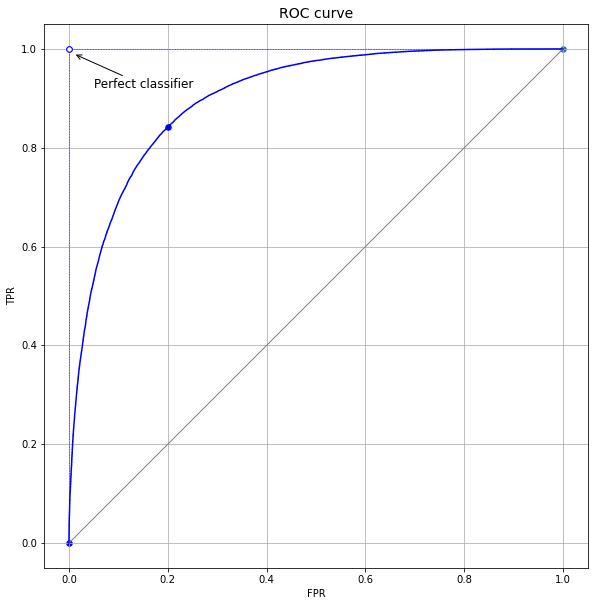

In [31]:
fig, ax = roc_plot()

roc = ax.plot(fprs,tprs, color='blue');
ax.scatter([fpr],[tpr],s = 30, color='blue', zorder=5)

ax.set_title("ROC curve", fontsize=14);
ax.plot([0,1],[0,1],'-', c='grey', linewidth = 1 )
ax.plot([0,0,1],[0,1,1],'--', c = roc[0].get_color() , linewidth=0.5)
ax.scatter([0],[0],s = 30, c = roc[0].get_color() )
ax.scatter([1],[1],s = 30)
ax.scatter([0],[1],s = 30, edgecolor='blue', facecolor='white', zorder=5)
ax.scatter([0],[1],s = 30, edgecolor='blue', facecolor='white', zorder=5)
ax.grid()

ax.annotate("Perfect classifier",(0.01,0.99),(0.05, 0.92), arrowprops = {'arrowstyle':'-> '}, fontsize=12);

As we can see we must compromise, the  perfect classfier corresponds to point (0,1) and does not lie on our curve. We can increase TPR but only by increasing FPR. 

In extreme cases we may clasify everybody as men. Then FPR = 0 but also TPR = 0. Other extreme would be to classify everybody as women. Then we have TPR = 1 but also FPR = 1. So the ROC curve always start at (0,0) and ends at (1,1). 

The diagonal black line represents random guessing. If you classify somebody randomly as a woman with probability $r$ then true positives rate is also $r$. But so is the false positives rate. This gives as a $(r,r)$ point on the plot. Changing $r$ we can get the whole diagonal. 

## Optimal threshold

So how do we chose a point on ROC curve ? That depends on our goals, we need some criterion, so let's say we want to minimize the number of misclasifications (or maximize accuracy). 

From the definitions: 

$$FP +FN = FPR\cdot N + FNR\cdot P = FPR\cdot N+ (1-TPR)\cdot P \propto FPR\cdot P(N) + (1-TPR)\cdot P(P) $$ 

Please remember that positives are women and negatives are men:) The above formula translates into Python

In [32]:
errs = fprs*0.5+(1-tprs)*0.5

We look for the index containing the minimal value which can be used to access corresponding threshold value

In [33]:
imin = np.argmin(errs)
print(imin, thds[imin])

13682 0.517016222693121


So as expected the optimal treshold is equal to 1/2 (within our Monte-Carlo accuracy). 

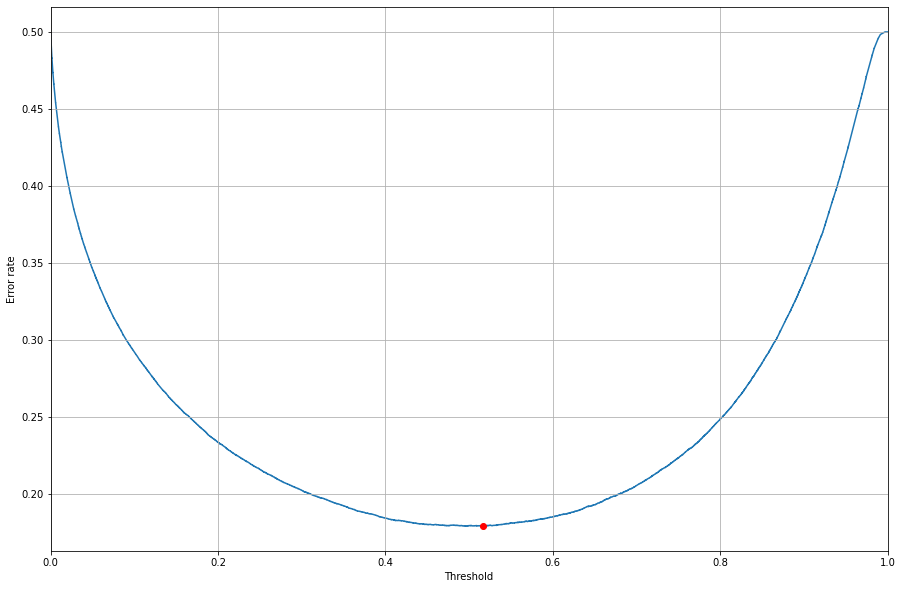

In [34]:
fig, ax = plt.subplots()
ax.set_ylabel("Error rate")
ax.set_xlabel("Threshold")
ax.set_xlim(0,1)
ax.plot(thds,errs, zorder=1)
ax.grid()
ax.scatter([thds[imin]], [errs[imin]], c='red', zorder=2);

### Error costs

More often we are interested not so much in accuracy but in total cost of the mistakes. And as already stated the costs of different types of error can be different. 

Imagine for example such scenario: You classify a person and  if you decide it's a woman you invite her to candlelight dinner. If it's a man you invite him for a beer. You live in a rather conservative society where when a man is invited to a candlelight diner  he will knock you teeths off. If you invite a woman for a beer she will slap you. How should you choose a treshold in this case? 

To answer this question you have to  assign a cost to each type of errors. Let's assume that you consider the cost of your teeth as five times bigger then cost of being slapped in the face. Then the expected cost is: 

$$c_2\cdot FPR\cdot P(P)+ c_1\cdot (1-TPR)\cdot P(N)$$ 

with 

$$c_2 = 5\quad c_1 = 1$$  

We can redo the calculations with the new cost estimate

In [35]:
errs_c = 5 * fprs+1*(1-tprs)

In [36]:
imin_c = np.argmin(errs_c)
print(imin, thds[imin_c])

13682 0.8322703185885568


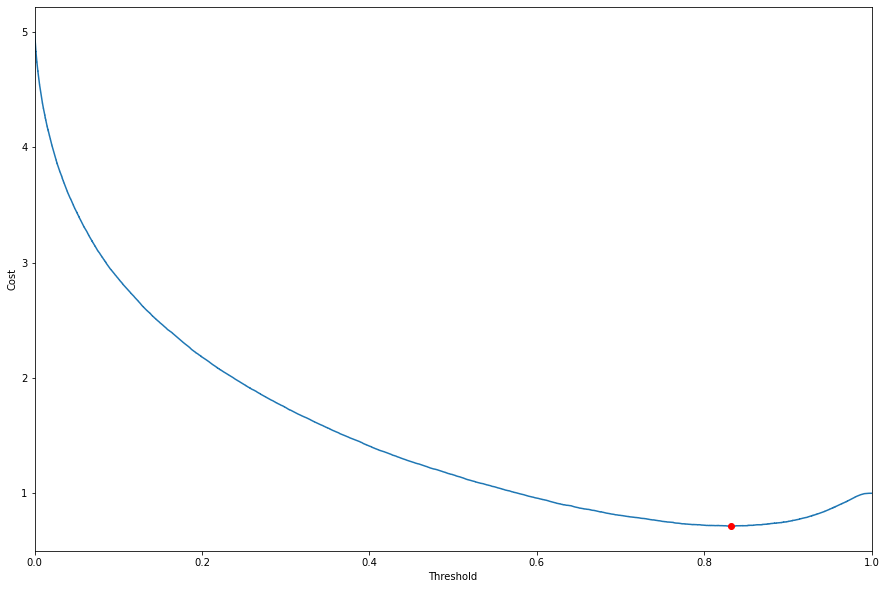

In [37]:
fig, ax = plt.subplots()
ax.set_ylabel("Cost")
ax.set_xlabel("Threshold")
ax.set_xlim(0,1)
ax.plot(thds,errs_c, zorder=1)
ax.scatter([thds[imin_c]], [errs_c[imin_c]], c='red', zorder=2);

Now the treshold is considerably higher. That's logical as mistaking men for women (false positive) is more costly, you want to be more sure that this is a woman before  asking this person out on   date. 
A look at the ROC curve shows that we have indeed decreased the false positives rate but at the expense of decreasing the true positive rate as well. 

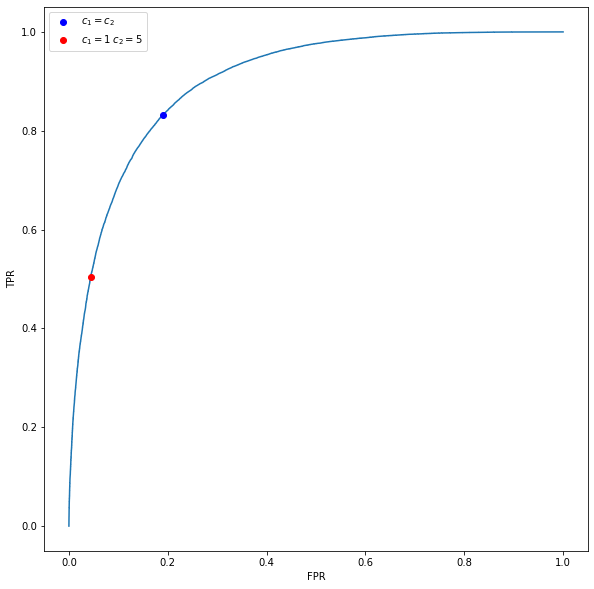

In [38]:
fig, ax = roc_plot()
ax.plot(fprs, tprs, zorder=1)
ax.scatter([fprs[imin]], [tprs[imin]], c='blue', zorder=2, label='$c_1 = c_2$' );
ax.scatter([fprs[imin_c]], [tprs[imin_c]], c='red', zorder=2, label="$c_1=1\;c_2=5$");
ax.legend();

Actually we did not need to search  the optimal treshold as above. There is a theorem that states that given the costs the optimal treshold is 

### Optimal threshold

$$ \frac{c_2}{c_1+c_2}$$

which in this case is equal to

In [39]:
5/6

0.8333333333333334

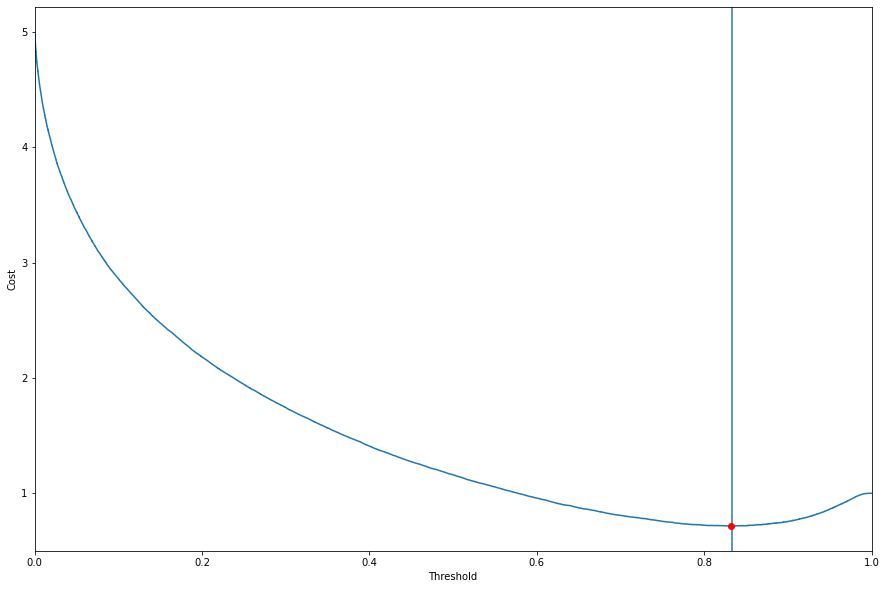

In [40]:
fig, ax = plt.subplots()
ax.set_xlim(0.,1)
ax.set_ylabel("Cost")
ax.set_xlabel("Threshold")
ax.plot(thds,errs_c, '-', zorder=1)
ax.scatter([thds[imin_c]], [errs_c[imin_c]], c='red', zorder=2);
ax.axvline(5/6, zorder=1);

which is resonably close to our value. The agreement is not perfect because our calculations were based on finite size sample. 

### AUC score

As we have learned a probabilistic classifier actually represents a whole familly of classifiers that is parametrized by the classification threshold and can be visualised by the ROC curve. It would be convenient to be able to summarise the performance of this familly with a single number. This can be achieved with _area under the curve_  (AUC) score. As the name implies this is the area under the ROC curve. We can use `roc_auc_score` function from scikit-learn to calculate it. This function takes same arguments as `roc_curve`

In [41]:
auc = roc_auc_score(labels, pdf_F_cond(h_FM))

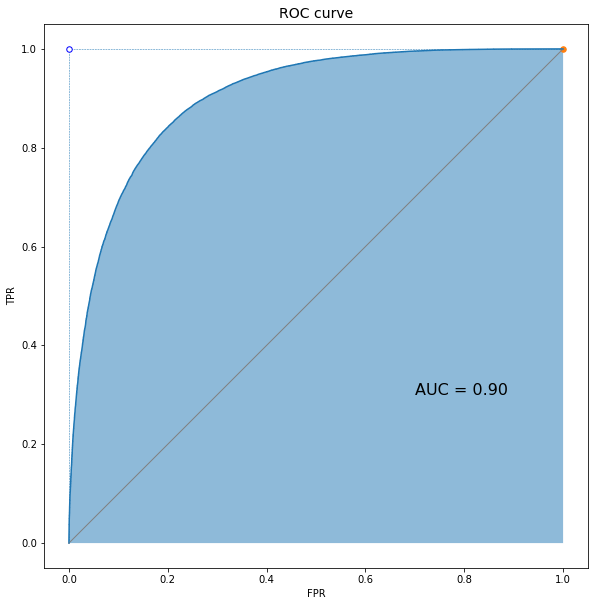

In [42]:
fig, ax = roc_plot()
roc = ax.plot(fprs,tprs);
ax.fill_between(fprs,tprs,alpha=0.5);

ax.set_title("ROC curve", fontsize=14);
ax.plot([0,1],[0,1],'-', c='grey', linewidth = 1 )
ax.plot([0,0,1],[0,1,1],'--', c = roc[0].get_color() , linewidth=0.5)
#ax.scatter([0],[0],s = 30, c = roc[0].get_color() )
ax.scatter([1],[1],s = 30)
ax.scatter([0],[1],s = 30, edgecolor='blue', facecolor='white', zorder=5)

ax.text(0.7, 0.3, "AUC = %3.2f"%(auc,), fontsize=16 );

Properties of the ROC curve imply that for the perfect classifier $AUC=1$ and for random guessing $AUC=0.5$. You can learn more about ROC curves and AUC _e.g._ in [here](https://www.researchgate.net/publication/284001844_Some_mathematical_properties_of_the_ROC_curve_and_their_applications). 

## But where is "Learning" ??

By now you may be wondering what all this got to do with learning? We have a classifier but when did it "learn" to classify ? 

I hope that by now you do realize that the properties of the classifier are enocoded in the distributions

$$P(D=d|C=c)\quad\text{and}\quad P(C=c)$$

so learning amounts to estimating  this distribution from the data. 

In our case we just took the numbers provided by the Central Statistical Office and assumed (!) that the underlying distribution was normal. Actually this is not true. What I did was to take the data for persons in the age group 20-29 years. Actually the mean and the stadard deviation depends on the age group  droping _e.g._ to 174cm for men in age group 50-59 years. That means that the overall distribution in  the male population cannot be normal. It could be however a good (or good enough approximation). This is impossible to check without the actual data.  Unfotunately I do not have the access to the original data on which those measurments were based. 

The only data I could find was [kaggle dataset](https://www.kaggle.com/mustafaali96/weight-height). This data set does not contain any description but use of inches and pounds suggests an american or english origin. The data consists of 10000 points each specifying sex, height and weight of one person. I will use this dataset  to estimate the parameters of the $P(H=h|S=s)$ distributions. This will be the subject of teh next classification_naive_bayes  notebook.  